In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Data transformations for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR-10 datasets
train_dataset = datasets.CIFAR10(root="./cifar-10", train=True, transform=transform, download=False) #set download=true jika ingin download
test_dataset = datasets.CIFAR10(root="./cifar-10", train=False, transform=transform, download=False) #set download=true jika ingin download

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define CNN model
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 4096), nn.ReLU(),
            nn.Linear(4096, 1024), nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, output_size)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Define MLP model
class MLP(nn.Module):
    def __init__(self, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 2048), nn.ReLU(), nn.BatchNorm1d(2048),
            nn.Linear(2048, 1024), nn.ReLU(), nn.BatchNorm1d(1024),
            nn.Linear(1024, 512), nn.ReLU(), nn.BatchNorm1d(512),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3), nn.BatchNorm1d(256),
            nn.Linear(256, output_size)  # No softmax, handled by CrossEntropyLoss
        )

    def forward(self, x):
        return self.layers(x)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.to(device)
    scaler = GradScaler()  # GradScaler for mixed precision training
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast(device_type=device):  # Mixed precision enabled
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        scheduler.step(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Metrics -> Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            y_prob.extend(F.softmax(outputs, dim=1).cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc = roc_auc_score(np.eye(10)[y_true], np.array(y_prob), average='macro', multi_class='ovr')

    print(f"Test Metrics -> Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    plt.figure(figsize=(10, 8))
    y_true_binarized = np.eye(output_size)[y_true]
    for i in range(output_size):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], np.array(y_prob)[:, i])
        auc_i = roc_auc_score(y_true_binarized[:, i], np.array(y_prob)[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_i:.4f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (One-vs-Rest)')
    plt.legend()
    plt.tight_layout()
    plt.show()

output_size = 10
epochs_number_cnn = 25  # Number of epochs CNN
epochs_number_mlp = 25  # Number of epochs MLP

criterion = nn.CrossEntropyLoss()

Using device: cuda


Training CNN...
Epoch 1/25, Train Metrics -> Loss: 1.5094, Accuracy: 0.4407
Epoch 2/25, Train Metrics -> Loss: 1.1342, Accuracy: 0.5923
Epoch 3/25, Train Metrics -> Loss: 0.9701, Accuracy: 0.6538
Epoch 4/25, Train Metrics -> Loss: 0.8514, Accuracy: 0.6986
Epoch 5/25, Train Metrics -> Loss: 0.7671, Accuracy: 0.7287
Epoch 6/25, Train Metrics -> Loss: 0.6993, Accuracy: 0.7523
Epoch 7/25, Train Metrics -> Loss: 0.6358, Accuracy: 0.7765
Epoch 8/25, Train Metrics -> Loss: 0.5863, Accuracy: 0.7932
Epoch 9/25, Train Metrics -> Loss: 0.5309, Accuracy: 0.8129
Epoch 10/25, Train Metrics -> Loss: 0.4936, Accuracy: 0.8242
Epoch 11/25, Train Metrics -> Loss: 0.4523, Accuracy: 0.8402
Epoch 12/25, Train Metrics -> Loss: 0.4201, Accuracy: 0.8500
Epoch 13/25, Train Metrics -> Loss: 0.3887, Accuracy: 0.8613
Epoch 14/25, Train Metrics -> Loss: 0.3563, Accuracy: 0.8742
Epoch 15/25, Train Metrics -> Loss: 0.3251, Accuracy: 0.8827
Epoch 16/25, Train Metrics -> Loss: 0.2994, Accuracy: 0.8934
Epoch 17/25, Trai

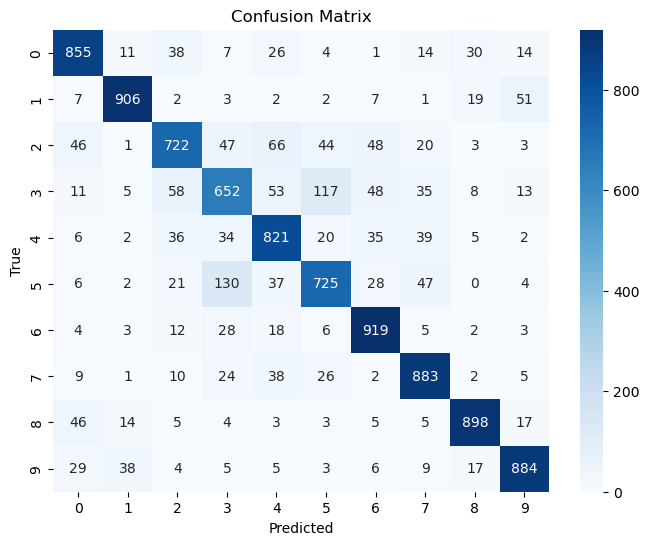

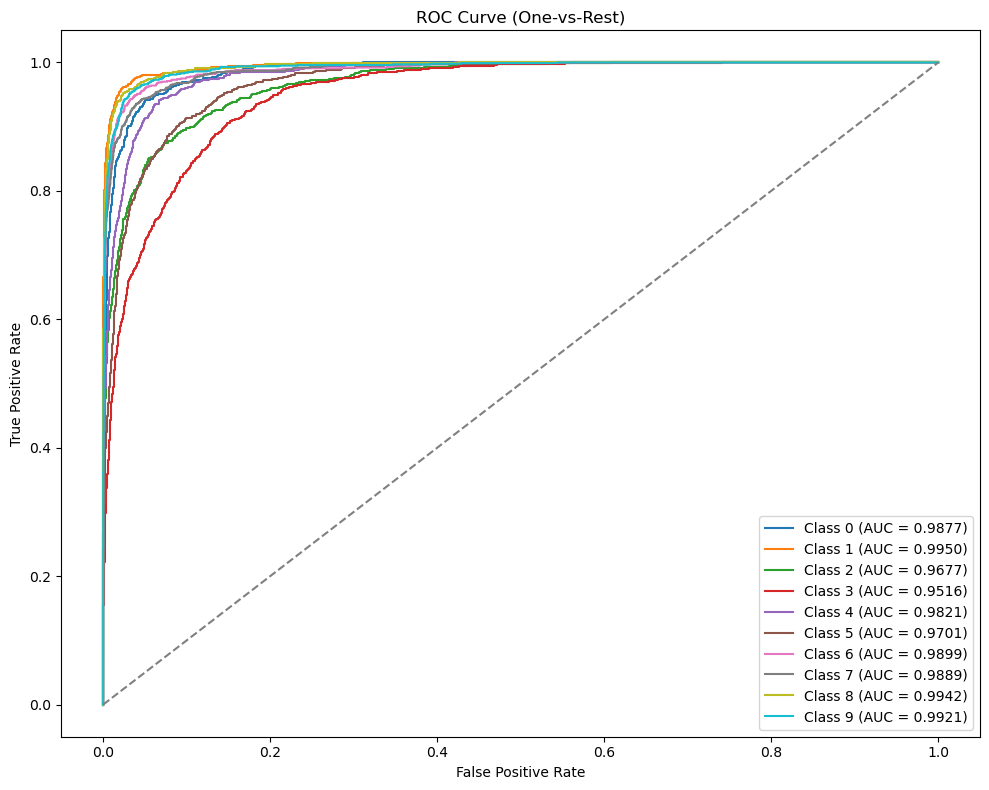

In [2]:
cnn_model = CNN(output_size).to(device)

cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001)

# Train and Evaluate CNN
print("Training CNN...")
train_model(cnn_model, train_loader, criterion, cnn_optimizer, epochs=epochs_number_cnn)
print("Evaluating CNN...")
evaluate_model(cnn_model, test_loader)

Training MLP...
Epoch 1/25, Train Metrics -> Loss: 1.6373, Accuracy: 0.4208
Epoch 2/25, Train Metrics -> Loss: 1.3917, Accuracy: 0.5080
Epoch 3/25, Train Metrics -> Loss: 1.2610, Accuracy: 0.5560
Epoch 4/25, Train Metrics -> Loss: 1.1483, Accuracy: 0.5958
Epoch 5/25, Train Metrics -> Loss: 1.0444, Accuracy: 0.6343
Epoch 6/25, Train Metrics -> Loss: 0.9527, Accuracy: 0.6669
Epoch 7/25, Train Metrics -> Loss: 0.8555, Accuracy: 0.7012
Epoch 8/25, Train Metrics -> Loss: 0.7539, Accuracy: 0.7391
Epoch 9/25, Train Metrics -> Loss: 0.6664, Accuracy: 0.7682
Epoch 10/25, Train Metrics -> Loss: 0.5741, Accuracy: 0.8035
Epoch 11/25, Train Metrics -> Loss: 0.4976, Accuracy: 0.8301
Epoch 12/25, Train Metrics -> Loss: 0.4366, Accuracy: 0.8521
Epoch 13/25, Train Metrics -> Loss: 0.3739, Accuracy: 0.8736
Epoch 14/25, Train Metrics -> Loss: 0.3286, Accuracy: 0.8887
Epoch 15/25, Train Metrics -> Loss: 0.2902, Accuracy: 0.9022
Epoch 16/25, Train Metrics -> Loss: 0.2553, Accuracy: 0.9138
Epoch 17/25, Trai

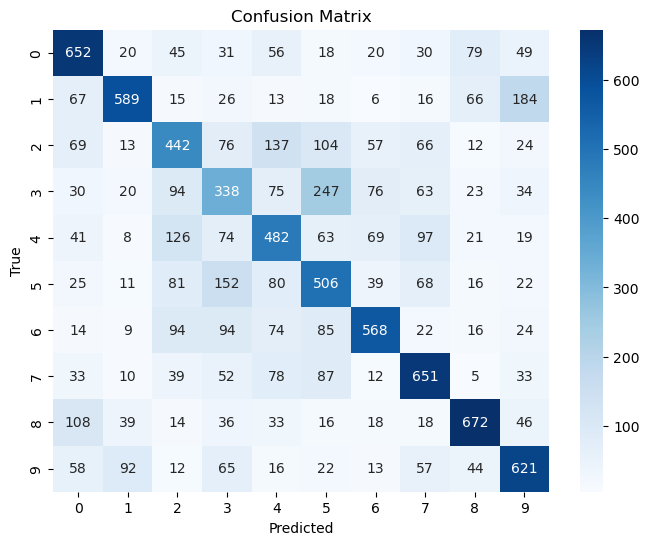

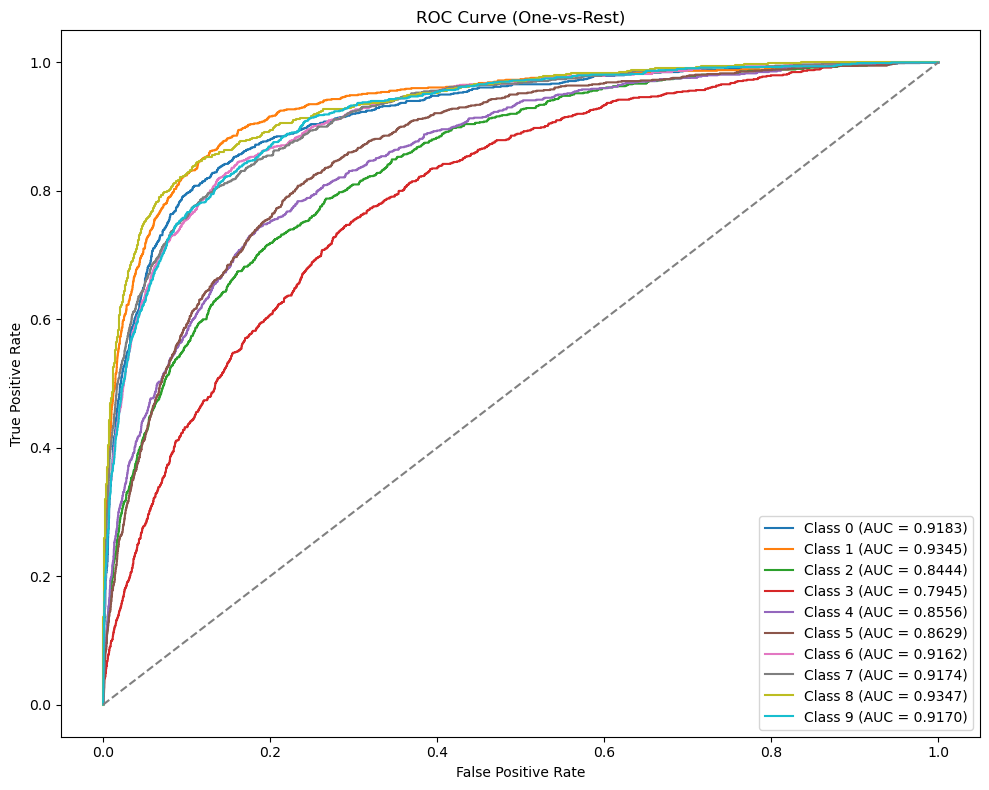

In [3]:
mlp_model = MLP(output_size).to(device)

mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.0001)

# Train and Evaluate MLP
print("Training MLP...")
train_model(mlp_model, train_loader, criterion, mlp_optimizer, epochs=epochs_number_mlp)
print("Evaluating MLP...")
evaluate_model(mlp_model, test_loader)

## Hasil PyTorch

Dari hasil train dan evaluasi dengan test untuk **CNN**, didapatkan:
1. **Training Time**: 11 menit 56 detik
2. **Train Accuracy akhir yang didapat**: 0.9447
3. **Test Accuracy akhir yang didapat**: 0.8265

Dari hasil train dan evaluasi dengan test untuk **MLP**, didapatkan:
1. **Training Time**: 13 menit 40 detik
2. **Train Accuracy akhir yang didapat**: 0.9552
3. **Test Accuracy akhir yang didapat**: 0.5521

Dari hasil dengan PyTorch dan epoch yang sama (25), Test Accuracy CNN dengan Train Accuracy-nya berbeda agak jauh, namun Test Accuracy CNN masih bisa di atas 75% sedangkan Test Accuracy MLP jauh di bawah CNN dan minimum 75%. Tidak hanya itu, semua Test Metrics lain untuk MLP hasilnya sangat rendah dibanding CNN. Informasi lain: Train Accuracy CNN sedikit lebih rendah karena memakai banyak Dropout() dibandingkan MLP.

# Penjelasan Persamaan Matematika dan Evaluasi

## Model: CNN (Convolutional Neural Network)
### Komponen CNN:
1. **Conv2d**: Operasi convolusi yang mempelajari filter untuk fitur spasial.
   - $$\text{Output size (Conv2D)} = \frac{(W - K + 2P)}{S} + 1$$
   - Keterangan -> $W$: Lebar input, $K$: Kernel size, $P$: Padding, $S$: Stride.

2. **ReLU Activation**: Fungsi aktivasi $\text{ReLU}(x) = \max(0, x)$.

3. **MaxPooling**: Operasi downsampling untuk mengurangi dimensi.
   - $\text{Output size (MaxPool)} = \frac{(W - K)}{S} + 1$
   
4. **Fully Connected Layer**:
   - $\text{y} = \text{Wx} + \text{b}$, di mana $W$ adalah bobot dan $b$ bias.

CNN mendekati output dengan fungsi Softmax:
$$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$$

## 3. Metrik Evaluasi
### 1. Accuracy
**Kegunaan**: Mengukur sejauh mana prediksi model secara keseluruhan benar.  
**Rumus**:
$$
\text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Samples}}
$$

**Titik Bagus**: Biasanya, accuracy tinggi (>80%) adalah indikasi bahwa model bekerja dengan baik, namun perlu hati-hati dengan dataset yang tidak seimbang karena accuracy bisa menipu.


### 2. Precision
**Kegunaan**: Mengukur seberapa andal model saat memprediksi suatu kelas tertentu sebagai positif.  
**Rumus**:
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

**Titik Bagus**: Precision tinggi (>70%) ideal untuk kasus di mana False Positives sangat berbahaya, seperti diagnosis penyakit langka atau deteksi penipuan.


### 3. Recall
**Kegunaan**: Mengukur kemampuan model untuk mendeteksi semua instance positif dalam data.  
**Rumus**:
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

**Titik Bagus**: Recall tinggi (>70%) penting jika False Negatives lebih kritis, seperti pada sistem keamanan atau deteksi kebakaran.


### 4. F1 Score
**Kegunaan**: Merupakan rata-rata harmonis dari Precision dan Recall, memberikan keseimbangan ketika penting untuk memperhatikan keduanya.  
**Rumus**:
$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

**Titik Bagus**: Nilai F1 di atas 0.7 umumnya dianggap baik, terutama pada dataset yang tidak seimbang.


### 5. Area Under Curve (AUC)
**Kegunaan**: Mengukur kemampuan model untuk membedakan antara kelas positif dan negatif, dihitung dari ROC Curve.  
**Rumus (integral)**:
$$
\text{AUC}_{\text{ROC}} = \int_{0}^{1} \text{TPR}(\text{FPR}) \, d\text{FPR}
$$

**Titik Bagus**: AUC mendekati 1 menunjukkan model sangat baik dalam membedakan kelas; AUC di bawah 0.5 menandakan performa buruk (seperti tebak acak).


### Interpretasi Umum
- **Model yang baik** tidak hanya memiliki accuracy tinggi, tetapi juga keseimbangan antara precision, recall, dan F1.
- **Dataset tidak seimbang**: Fokus pada precision, recall, atau F1 daripada hanya bergantung pada accuracy.
- **AUC tinggi** menunjukkan model dapat diandalkan untuk membedakan kelas dengan baik, meski tidak sepenuhnya menangkap kesalahan spesifik seperti recall rendah.


## 4. Evaluasi Model
Hasil evaluasi menggunakan **Confusion Matrix** dan **ROC Curve**:
1. **Confusion Matrix**:
   - Baris: True class.
   - Kolom: Predicted class.
2. **ROC Curve** untuk setiap kelas:
   - Sumbu X: False Positive Rate (FPR).
   - Sumbu Y: True Positive Rate (TPR).

